In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from LB_D2Q9 import pipe_cython as lb
from LB_D2Q9 import pipe_opencl as lb_cl

We now want to visualize the evolution of the flow...let's see how it goes...

In [6]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [8]:
#### Input to the simulation in SI. ######
diameter = 2. # meters
length = 4. # meters

deltaP = -.005

dr = 0.005
dt = dr**2

viscosity = 10.**-6. # More viscous = easier to simulate!

##### Derived parameters ######
print 'Desired viscosity:' , viscosity
#Re = (input_velocity * diameter)/viscosity
#print 'Desired Re', Re

# Re is set by diameter, input_velocity, and viscosity
# Adjust dr so that mach number doers not explode!
print
print '###### Simulation Parameters #########'
print

# Solve for the desired omega...make sure it's in the correct range.


ly = int(np.ceil(diameter/dr))
lx = int(np.ceil(length/dr))
print 'ly', ly
print 'lx', lx

nx = lx + 1
ny = ly + 1

omega = .5 + (3*dt*viscosity)/(dr**2)

print 'omega:' , omega

assert (omega > 0.5) and (omega < 1)

obstacle_size=.25 # meters

Desired viscosity: 1e-06

###### Simulation Parameters #########

ly 400
lx 800
omega: 0.500003


In [9]:
nx*ny*9

2890809

In [22]:
import skimage as ski
import skimage.draw

In [23]:
import sys

In [24]:
sim = lb.Pipe_Flow(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP)

In [25]:
two_d_local_size = (32, 32)
three_d_local_size = (32, 32, 1)

sim_cl = lb_cl.Pipe_Flow(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP, two_d_local_size=two_d_local_size,
                        three_d_local_size=three_d_local_size)

2d global: (832, 416)
2d local: (32, 32)
3d global: (832, 416, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192, 8192, 8192]
---------------------------
This context is associated with  1 devices


In [26]:
%%prun

sim.run(200)

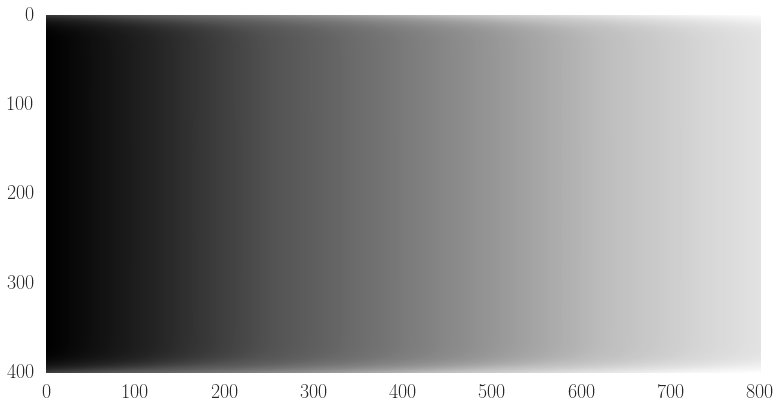

In [27]:
plt.imshow(sim.feq[5, :, :].T)
plt.grid(False)

<matplotlib.colorbar.Colorbar instance at 0x7f60f68a8c20>

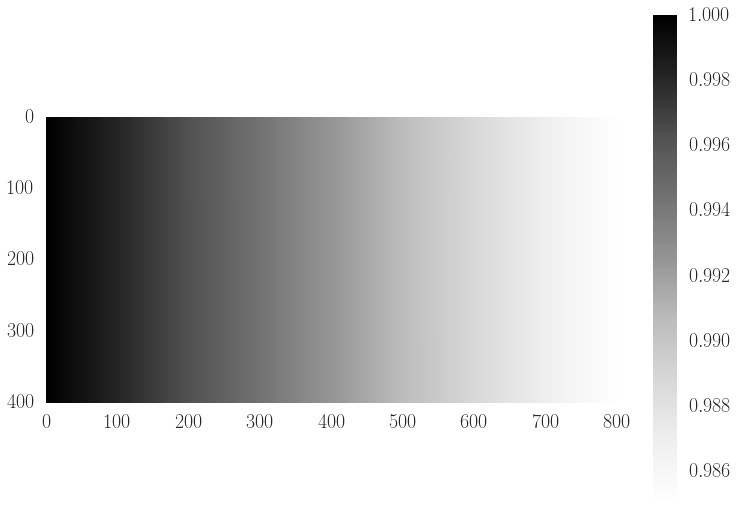

In [28]:
plt.imshow(sim.rho.T)
plt.grid(False)
plt.colorbar()

So on my cpu, this takes about 35.6 seconds. The majority of the time is in the update_feq section.

In [29]:
%%prun

sim_cl.run(200)

<matplotlib.colorbar.Colorbar instance at 0x7f60f019e9e0>

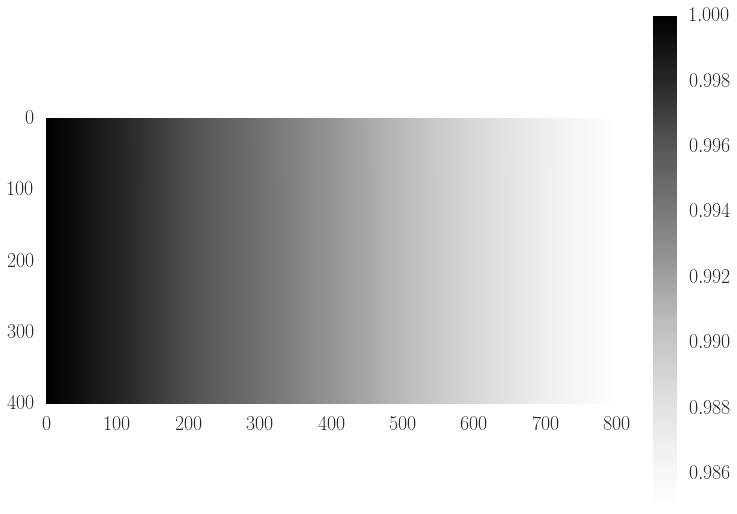

In [18]:
fields = sim_cl.get_fields_on_cpu()
plt.imshow(fields['rho'].T)
plt.grid(False)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f60e889d170>

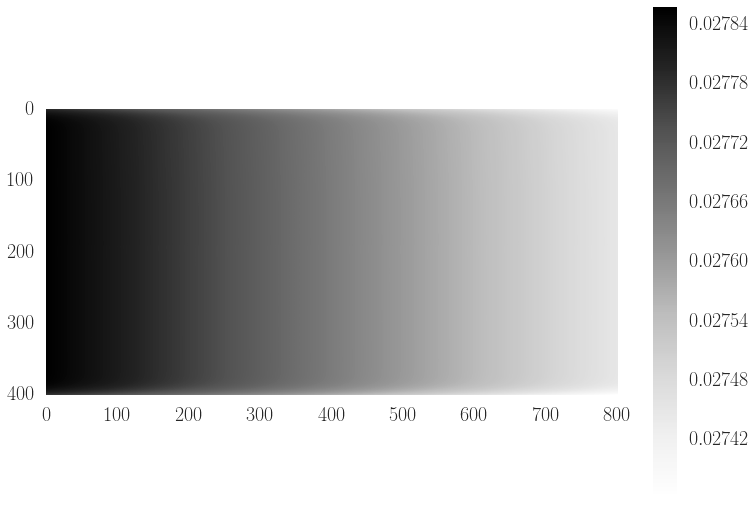

In [19]:
fields = sim_cl.get_fields_on_cpu()
plt.imshow(fields['feq'][:, :, 5].T)
plt.grid(False)
plt.colorbar()

This takes about 4 seconds. A speedup by a factor of 10! Awesome! Now if we could speedup the move and update_feq pieces, this would be even faster.

Nice. It runs *very* fast on the GPU!

Let's make sure the velocity on the walls is basically zero...

<matplotlib.colorbar.Colorbar instance at 0x7f60e857ee60>

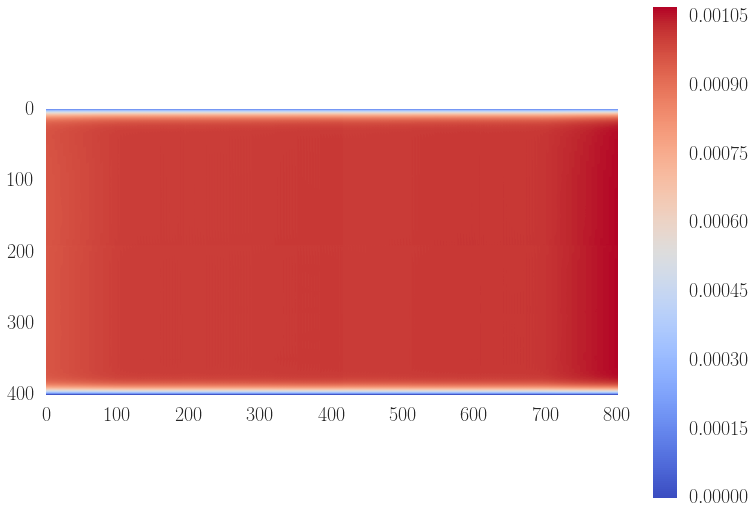

In [20]:
fields = sim_cl.get_fields_on_cpu()
u = fields['u']
v = fields['v']
mag_cl = np.sqrt(u**2 + v**2)
plt.imshow(u.T, cmap=cm.coolwarm)
plt.grid(False)
#plt.clim(0, 1)
plt.colorbar()

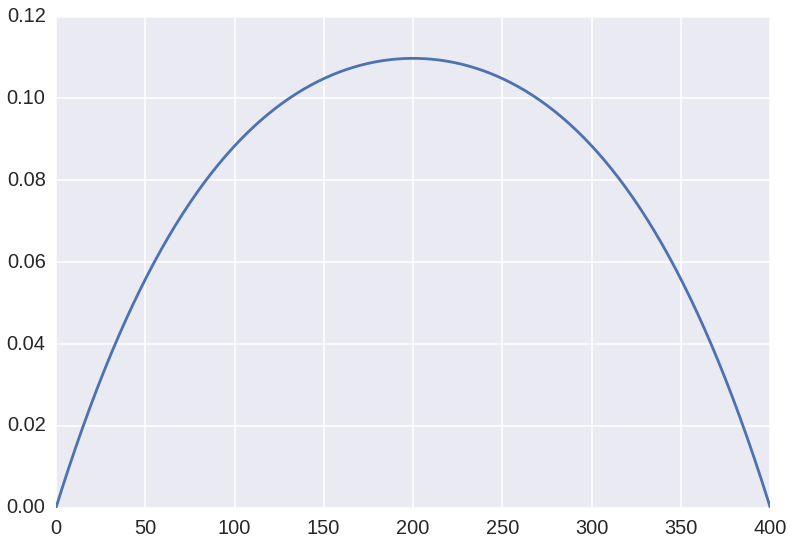

In [35]:
plt.plot(u[200, :])

<matplotlib.colorbar.Colorbar instance at 0x7fca448233b0>

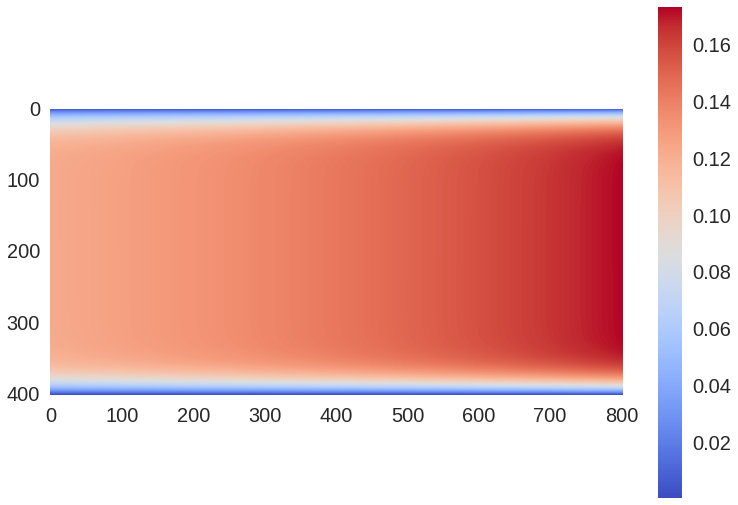

In [19]:
mag = np.sqrt(sim.u**2 + sim.v**2)
plt.imshow(mag.T, cmap=cm.coolwarm)
plt.grid(False)
#plt.clim(0,1)
plt.colorbar()

Well, this basically looks correct...let's compare the two. The corners are definitely different though. And the walls.

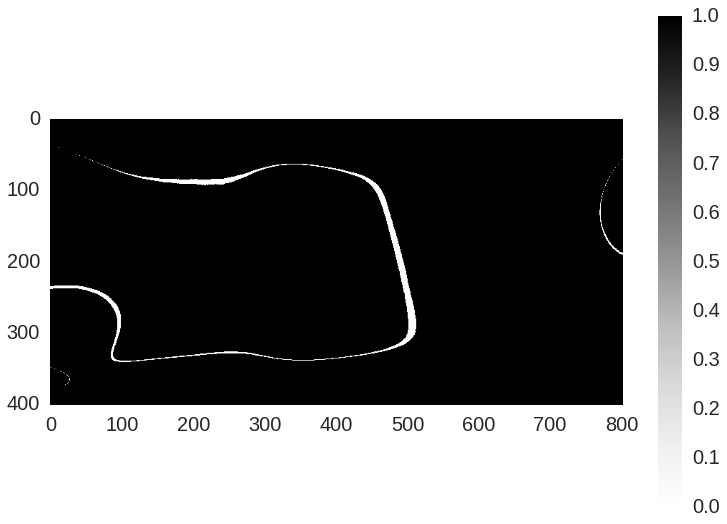

In [20]:
differences = np.abs(mag_cl - mag) > 10.**-6.
plt.imshow(differences.T, interpolation=None)
plt.colorbar()
plt.grid(False)

<matplotlib.colorbar.Colorbar instance at 0x7fca4133dcb0>

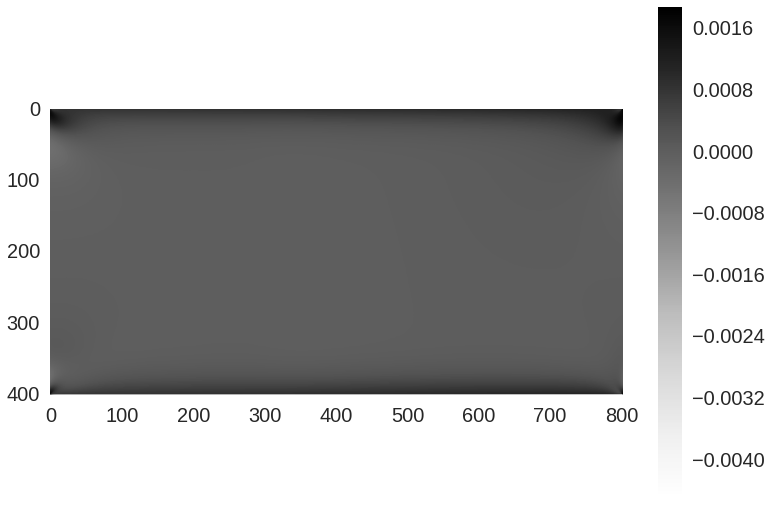

In [21]:
plt.imshow((mag_cl - mag).T)
plt.grid(False)
plt.colorbar()

Interesting. So the problem areas appear to be the walls now...and only the walls! Interesting...

Well...it looks reasonably correct now...

<matplotlib.colorbar.Colorbar instance at 0x7fa8c0035320>

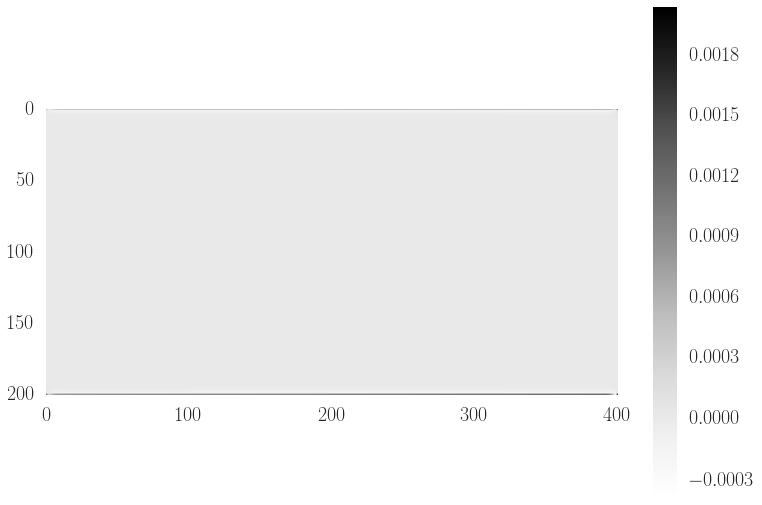

In [23]:
plt.imshow((mag_cl - mag).T)
plt.grid(False)
plt.colorbar()

OMG. I think it works! :D

In [13]:
def check_variable(varname):
    sim_cl_field = sim_cl.get_fields_on_cpu()[varname]
    
    if varname == 'rho':
        sim_field = sim.rho
    if varname == 'u':
        sim_field = sim.u
    if varname == 'v':
        sim_field = sim.v
    if varname == 'feq':
        sim_field = sim.feq
        # Have to reshape it...ugh.
        sim_field = np.rollaxis(sim_field, 0, 3)
    if varname == 'f':
        sim_field = sim.f
        sim_field = np.rollaxis(sim_field, 0, 3)
    return sim_field, sim_cl_field

In [24]:
sim.move_bcs()
sim_cl.move_bcs()

In [25]:
sim.move()
sim_cl.move()

I'm so confused. Somehow, running the move_bcs command did nothing...

In [26]:
field, field_cl = check_variable('f')

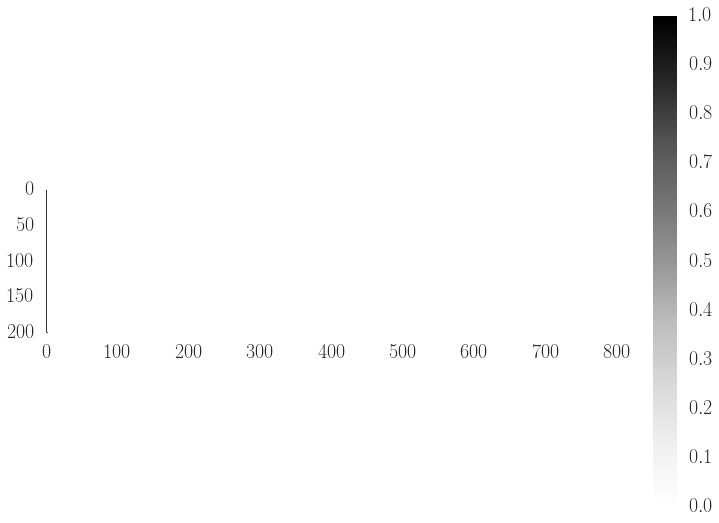

In [27]:
# They should be exactly the same
fieldnum = 1
problems = np.abs(field[:, :, fieldnum] - field_cl[:, :, fieldnum]) > 10.**-6.
plt.imshow(problems.T)
plt.clim(0, 1)
plt.colorbar()
plt.grid(False)

Ok, interesting...there must be something wrong with my boundaries for the different jumpers!

Ok, fields 6 & 8 are still not cooperating...we'll have to figure out why that is.

Now, everything is fine...lol

In [28]:
print field[5, 5, 3]
print field_cl[5, 5, 3]

0.110778
0.110778


Interesting...why does the opencl seem to be better behaved? lol

6 and 8 are the problems. evidently.

In [29]:
problems[lx, ly]

False

Only the edges appear crazy...

In [ ]:
rho = sim.get_fields_on_cpu()['rho']
print np.max(rho)
print np.min(rho)

In [ ]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['rho'].T)
plt.colorbar()
plt.grid(False)

In [ ]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['u'].T)
plt.colorbar()
plt.grid(False)

Yeah the boundaries still look utterly psychotic. lol. Not sure what's up with them! F & feq still look reasonable...so it's probably in an update function...

In [ ]:
fields = sim.get_fields_on_cpu()
plt.imshow(fields['v'].T)
plt.colorbar()
plt.grid(False)

In [ ]:
fields = sim_cl.get_fields_on_cpu()
plt.imshow(np.sum(fields['feq'],axis=2).T)
plt.colorbar()
plt.grid(False)

In [ ]:
fields = sim.get_fields_on_cpu()
plt.imshow(np.sum(fields['f'], axis=2).T)
plt.colorbar()
plt.grid(False)

In [ ]:
sim.run(10)

In [ ]:
wat = sim.get_fields_on_cpu()['u']**2 + sim.get_fields_on_cpu()['v']**2
plt.imshow(wat.T, cmap = cm.coolwarm)
plt.grid(False)
plt.colorbar()

Yeah this is not correct lol. It explodes!

In [ ]:
sim.get_fields_on_cpu()['rho']

LOL

Interesting...weird streaks are forming! Disaster...lol.

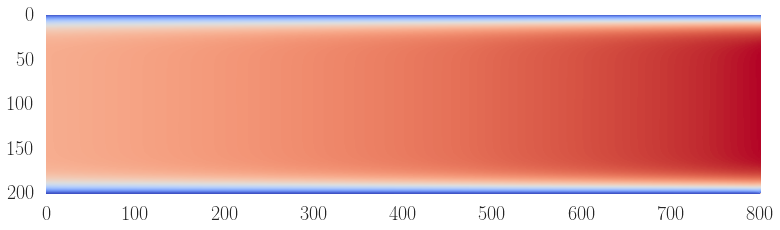

KeyboardInterrupt: 

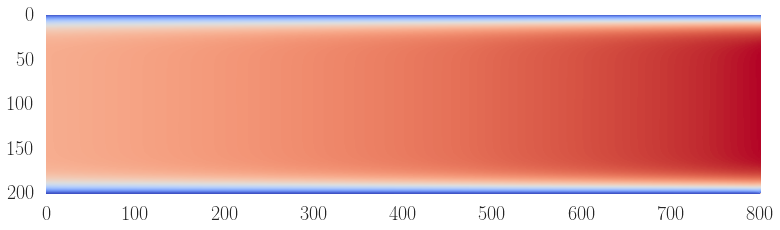

In [12]:
total_num_steps = 5000
steps_per_image= 25

num_to_record = int(np.ceil(float(total_num_steps)/steps_per_image))

Re_list = []
Ma_list = []

plt.figure()
for i in range(num_to_record):
    sim.update_dimensionless_nums()
    Re_list.append(sim.Re)
    Ma_list.append(sim.Ma)
    print 'max non_dim u:', np.max(sim.u)
    print 'sum of mass' , np.sum(sim.rho)/(sim.nx*sim.ny)
    mag = np.sqrt(sim.u**2 + sim.v**2)
    plt.imshow(mag.T, cmap = cm.coolwarm)
    plt.grid(False)
    #plt.clim(vmin=0, vmax=1.)
    #if i == 0:
    #    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_image)
plt.clf() # This way a second figure does not appear at the end...

IDK how to convert...but let's just fit.

In [ ]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

In [ ]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!